In [80]:
import heapq
import copy


In [81]:
class GridCell:
    def __init__(self, x=-1, y=-1):
        # Constructor method that initializes a GridCell object with optional x and y coordinates.
        self.x = x
        self.y = y

    def __lt__(self, other):
        # Less-than comparison method used for sorting GridCell objects.
        # It compares first by x coordinate and, if equal, by y coordinate.
        if self.x != other.x:
            return self.x < other.x
        return self.y < other.y

    def __eq__(self, other):
        # Equality comparison method.
        # Two GridCell objects are considered equal if their x and y coordinates are the same.
        return self.x == other.x and self.y == other.y

    def __hash__(self):
        # Hashing method that allows GridCell objects to be used in sets and dictionaries.
        # It generates a unique hash value based on the tuple (x, y).
        return hash((self.x, self.y))


In [82]:
class Robot:
    def __init__(self, start, pickup, drop, goal):
        # Constructor method for the Robot class, initializes a Robot object.
        # Parameters:
        #   - start: The starting grid cell for the robot.
        #   - pickup: The grid cell where the robot picks up an item.
        #   - drop: The grid cell where the robot drops an item.
        #   - goal: The goal grid cell or destination for the robot.
        self.start = start
        self.pickup = pickup
        self.drop = drop
        self.goal = goal

class Node:
    def __init__(self, cell, parent, g, h):
        # Constructor method for the Node class, initializes a Node object.
        # Parameters:
        #   - cell: The grid cell associated with this node.
        #   - parent: The parent node in the search tree.
        #   - g: The cost from the start node to this node.
        #   - h: The heuristic estimate of the cost from this node to the goal.
        self.cell = cell
        self.parent = parent
        self.g = g  # Cost from the start node to this node
        self.h = h  # Heuristic (estimated cost from this node to the goal)

    def __lt__(self, other):
        # Less-than comparison method used for sorting Node objects.
        # It compares nodes based on their combined cost and heuristic (f = g + h).
        return (self.g + self.h) < (other.g + other.h)  # Compare based on f = g + h


In [83]:
class CBSNode:
    def __init__(self, agent_paths=None, cost=0):
        # Constructor method for the CBSNode class, initializes a CBSNode object.
        # Parameters:
        #   - agent_paths: A list of agent paths, each represented as a list of grid cells.
        #   - cost: The cost associated with this CBS node.
        self.agent_paths = agent_paths if agent_paths is not None else []
        self.cost = cost

def manhattan_distance(a, b):
    # Calculates the Manhattan distance between two grid cells 'a' and 'b'.
    # Parameters:
    #   - a: The first grid cell.
    #   - b: The second grid cell.
    # Returns:
    #   - The Manhattan distance between the two grid cells.
    return abs(a.x - b.x) + abs(a.y - b.y)


In [84]:
def has_conflict(path1, path2):
    # Checks if there is a conflict between two agent paths.
    # Parameters:
    #   - path1: The first agent's path represented as a list of grid cells.
    #   - path2: The second agent's path represented as a list of grid cells.
    # Returns:
    #   - True if a conflict is detected, False otherwise.
    for t in range(min(len(path1), len(path2))):
        if path1[t] == path2[t]:
            return True  # Conflict detected
    return False  # No conflict found

def resolve_conflicts(node):
    # Resolves conflicts between agent paths in a CBSNode.
    # Parameters:
    #   - node: A CBSNode object containing agent paths to be resolved.
    # Returns:
    #   - A new CBSNode with resolved conflicts.

    resolved_node = copy.deepcopy(node)  # Create a deep copy of the original CBSNode

    for i in range(len(node.agent_paths)):
        for j in range(i + 1, len(node.agent_paths)):
            path1 = node.agent_paths[i]
            path2 = node.agent_paths[j]

            if has_conflict(path1, path2):
                new_path1, new_path2 = [], []
                k = 0
                while k < min(len(path1), len(path2)):
                    if path1[k] == path2[k]:
                        break
                    else:
                        new_path1.append(path1[k])
                        new_path2.append(path2[k])
                    k += 1

                new_path1.append(path1[k])
                new_path2.append(path2[k - 1])
                k += 1

                while k < min(len(path1), len(path2) + 1):
                    new_path1.append(path1[k])
                    new_path2.append(path2[k - 1])
                    k += 1

                while k < len(path1):
                    new_path1.append(path1[k])
                    k += 1

                while k <= len(path2):
                    new_path2.append(path2[k - 1])
                    k += 1

                # Update the agent paths in the resolved CBSNode
                resolved_node.agent_paths[i] = new_path1
                resolved_node.agent_paths[j] = new_path2

    return resolved_node


In [85]:
def a_star_pathfinding(start, goal, grid):
    # A* pathfinding algorithm to find the shortest path from 'start' to 'goal' on a grid.
    # Parameters:
    #   - start: The starting grid cell.
    #   - goal: The goal grid cell.
    #   - grid: A 2D grid representing the environment where 0 indicates accessible cells.
    # Returns:
    #   - A list of grid cells representing the path from 'start' to 'goal'.

    # Define movement directions (up, down, left, right)
    dx = [1, 0, -1, 0]
    dy = [0, 1, 0, -1]

    open_set = []      # Priority queue for open nodes
    closed_set = set() # Set to track visited nodes

    # Create the start node with initial values and push it into the open_set
    start_node = Node(start, None, 0.0, manhattan_distance(start, goal))
    heapq.heappush(open_set, start_node)

    while open_set:
        current = heapq.heappop(open_set)  # Get the node with the lowest cost from open_set

        if current.cell == goal:
            # If the goal is reached, reconstruct and return the path
            path = []
            while current is not None:
                path.append(current.cell)
                current = current.parent
            path.reverse()
            return path

        closed_set.add(current.cell)  # Mark the current node as visited

        for i in range(4):
            new_x = current.cell.x + dx[i]
            new_y = current.cell.y + dy[i]

            if (
                0 <= new_x < len(grid)
                and 0 <= new_y < len(grid[0])
                and grid[new_x][new_y] == 0
            ):
                neighbor = GridCell(new_x, new_y)

                if neighbor not in closed_set:
                    # Calculate new values for the neighbor node
                    neighbor_g = current.g + 1.0
                    neighbor_h = manhattan_distance(neighbor, goal)
                    neighbor_node = Node(neighbor, current, neighbor_g, neighbor_h)

                    # Push the neighbor node into the open_set
                    heapq.heappush(open_set, neighbor_node)

    return []


In [86]:
def cbs(robots, grid):
    # CBS algorithm for solving multi-agent pathfinding problems.
    # Parameters:
    #   - robots: A list of Robot objects representing the agents.
    #   - grid: A 2D grid representing the environment where 0 indicates accessible cells.
    # Returns:
    #   - A CBSNode object representing the solution or an empty CBSNode if no solution is found.

    open_set = []  # Priority queue for open nodes (cost, node)

    # Create the initial CBSNode with empty paths and cost set to 0
    initial_node = CBSNode()
    initial_node.agent_paths = [[] for _ in range(len(robots))]
    initial_node.cost = 0

    # Generate initial paths for each robot using A* search
    for i, robot in enumerate(robots):
        path = []

        # Find paths from start to pickup, pickup to drop, and drop to goal
        path_from_start_to_pickup = a_star_pathfinding(robot.start, robot.pickup, grid)
        path_from_pickup_to_drop = a_star_pathfinding(robot.pickup, robot.drop, grid)
        path_from_drop_to_goal = a_star_pathfinding(robot.drop, robot.goal, grid)

        # Combine these paths while excluding the last cell of each segment
        path.extend(path_from_start_to_pickup[:-1])
        path.extend(path_from_pickup_to_drop[:-1])
        path.extend(path_from_drop_to_goal)

        initial_node.agent_paths[i] = path
        initial_node.cost = max(initial_node.cost, len(path))

    heapq.heappush(open_set, (initial_node.cost, initial_node))

    while open_set:
        _, current = heapq.heappop(open_set)  # Get the node with the lowest cost from open_set
        conflicts_exist = False

        # Check for conflicts between agent paths
        for i in range(len(current.agent_paths)):
            for j in range(i + 1, len(current.agent_paths)):
                if has_conflict(current.agent_paths[i], current.agent_paths[j]):
                    conflicts_exist = True
                    break
            if conflicts_exist:
                break

        if not conflicts_exist:
            return current  # Solution found

        resolved_node = resolve_conflicts(current)  # Resolve conflicts and create a new node
        heapq.heappush(open_set, (resolved_node.cost, resolved_node))

    return CBSNode()  # No solution found


In [87]:
import matplotlib.pyplot as plt
import numpy as np


def plot_paths(grid, solution):
    fig, ax = plt.subplots(figsize=(len(grid[0]), len(grid)))

    # Set the background color to transparent
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')

    # Plot the grid
    ax.imshow(np.array(grid), cmap='gray')

    # Define colors for each robot's path
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, path in enumerate(solution.agent_paths):
        if not path:
            continue

        x = [cell.x for cell in path]
        y = [cell.y for cell in path]

        # Plot the path for the current robot with a unique color
        ax.plot(y, x, marker='o', linestyle='-', color=colors[i], label=f'Robot {i + 1} Path')

    ax.legend()
    ax.set_title("Robot Paths")
    ax.set_xlabel("Columns")
    ax.set_ylabel("Rows")
    ax.grid(True)
    plt.show()


## Test case1

Solution found with total cost: 27
Robot 1 path: [(0, 0), (0, 1), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 13), (2, 14), (3, 14), (3, 15), (3, 14), (3, 13), (3, 12)]
Robot 2 path: [(5, 9), (5, 8), (5, 7), (5, 6), (5, 5), (4, 5), (4, 4), (4, 3), (4, 2), (4, 1), (5, 1), (5, 0), (5, 1), (5, 2), (4, 2), (4, 3), (4, 4), (3, 4), (3, 5), (2, 5), (1, 5), (1, 6), (1, 7), (0, 7), (0, 8), (0, 9), (0, 10)]
Robot 3 path: [(1, 7), (2, 7), (2, 6), (3, 6), (4, 6), (5, 6), (5, 5), (5, 4), (5, 5), (4, 5), (3, 5), (2, 5), (1, 5), (0, 5)]


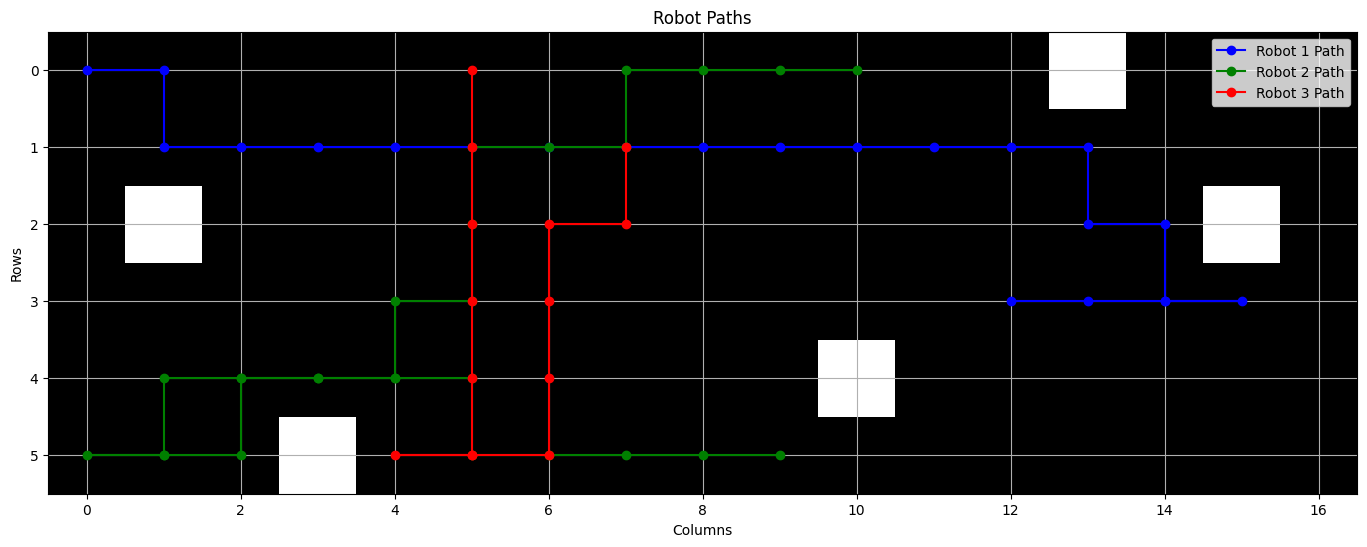

In [93]:
def main():
    # Define the grid with obstacles
    grid = [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]

    # Define the pickup and drop locations for products
    product_pickup_and_drop = [
        [GridCell(5, 0), GridCell(0, 8)],
        [GridCell(4, 6), GridCell(5, 4)],
        [GridCell(1, 12), GridCell(3, 15)]
    ]

    # Initialize the solution and minimum cost
    solution = CBSNode()
    min_cost = float('inf')

    # Iterate through all possible product assignments to robots
    for i in range(3):
        product_for_robot_1 = i
        product_for_robot_2, product_for_robot_3 = None, None
        second_assigned = False

        for j in range(3):
            if i != j:
                if not second_assigned:
                    product_for_robot_2 = j
                    second_assigned = True
                else:
                    product_for_robot_3 = j

        # Define robots with different product assignments
        robots_with_product_permut_1 = [
            Robot(GridCell(0, 0), product_pickup_and_drop[product_for_robot_1][0],
                  product_pickup_and_drop[product_for_robot_1][1], GridCell(3, 12)),
            Robot(GridCell(5, 9), product_pickup_and_drop[product_for_robot_2][0],
                  product_pickup_and_drop[product_for_robot_2][1], GridCell(0, 10)),
            Robot(GridCell(1, 7), product_pickup_and_drop[product_for_robot_3][0],
                  product_pickup_and_drop[product_for_robot_3][1], GridCell(0, 5))
        ]

        robots_with_product_permut_2 = [
            Robot(GridCell(0, 0), product_pickup_and_drop[product_for_robot_1][0],
                  product_pickup_and_drop[product_for_robot_1][1], GridCell(3, 12)),
            Robot(GridCell(5, 9), product_pickup_and_drop[product_for_robot_3][0],
                  product_pickup_and_drop[product_for_robot_3][1], GridCell(0, 10)),
            Robot(GridCell(1, 7), product_pickup_and_drop[product_for_robot_2][0],
                  product_pickup_and_drop[product_for_robot_2][1], GridCell(0, 5))
        ]

        # Find solutions for both product assignments
        temp_solution_1 = cbs(robots_with_product_permut_1, grid)
        temp_solution_2 = cbs(robots_with_product_permut_2, grid)

        # Choose the solution with minimum cost
        if temp_solution_1.cost < temp_solution_2.cost:
            if min_cost > temp_solution_1.cost:
                solution = temp_solution_1
        else:
            if min_cost > temp_solution_2.cost:
                solution = temp_solution_2

    # Display the solution
    if not solution.agent_paths:
        print("No solution found.")
    else:
        print(f"Solution found with total cost: {solution.cost}")
        for i, path in enumerate(solution.agent_paths):
            print(f"Robot {i + 1} path: {[(cell.x, cell.y) for cell in path]}")

        # Plot the paths on the grid
        plot_paths(grid, solution)

if __name__ == "__main__":
    main()


## Test case 2

Solution found with total cost: 24
Robot 1 path: [(0, 0), (0, 1), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (2, 14), (3, 14), (3, 15), (3, 14), (3, 13), (3, 12)]
Robot 2 path: [(5, 6), (5, 5), (5, 4), (4, 4), (4, 3), (4, 2), (5, 2), (5, 1), (5, 0), (5, 1), (5, 2), (4, 2), (4, 3), (3, 3), (3, 4), (2, 4), (1, 4), (1, 5), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10)]
Robot 3 path: [(1, 7), (2, 7), (2, 6), (3, 6), (4, 6), (5, 6), (5, 5), (5, 4), (5, 5), (4, 5), (3, 5), (2, 5)]


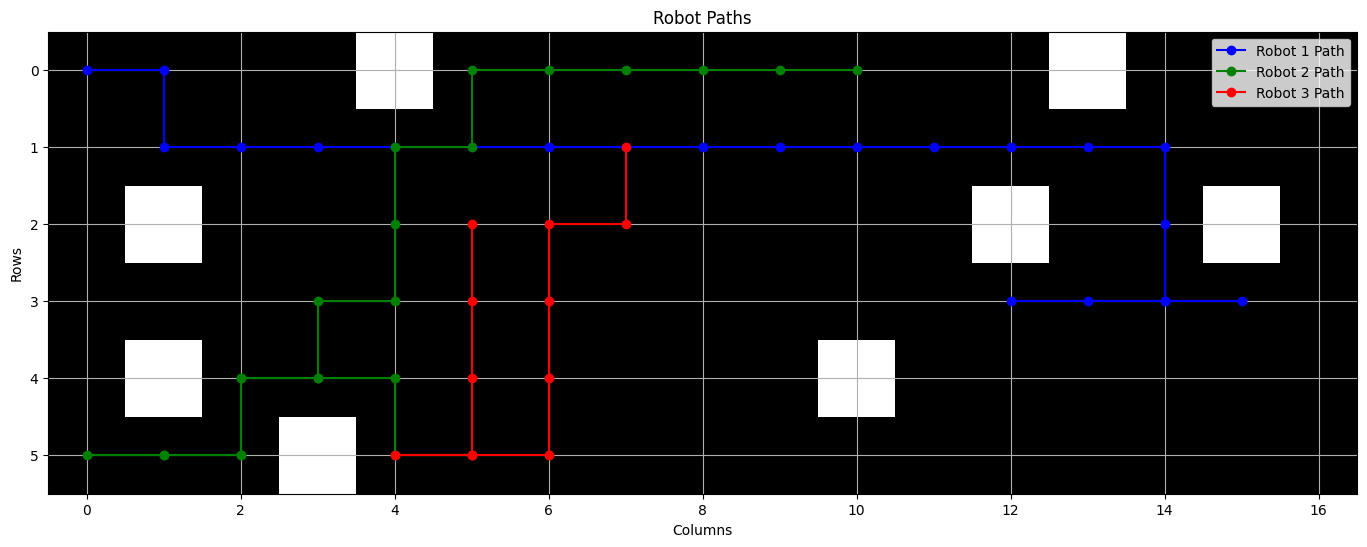

In [89]:
def main():
    grid = [
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]

    product_pickup_and_drop = [
        [GridCell(5, 0), GridCell(0, 8)],
        [GridCell(4, 6), GridCell(5, 4)],
        [GridCell(1, 14), GridCell(3, 15)]
    ]

    solution = CBSNode()
    min_cost = float('inf')

    for i in range(3):
        product_for_robot_1 = i
        product_for_robot_2, product_for_robot_3 = None, None
        second_assigned = False

        for j in range(3):
            if i != j:
                if not second_assigned:
                    product_for_robot_2 = j
                    second_assigned = True
                else:
                    product_for_robot_3 = j

        robots_with_product_permut_1 = [
            Robot(GridCell(0, 0), product_pickup_and_drop[product_for_robot_1][0],
                  product_pickup_and_drop[product_for_robot_1][1], GridCell(3, 12)),
            Robot(GridCell(5, 6), product_pickup_and_drop[product_for_robot_2][0],
                  product_pickup_and_drop[product_for_robot_2][1], GridCell(0, 10)),
            Robot(GridCell(1, 7), product_pickup_and_drop[product_for_robot_3][0],
                  product_pickup_and_drop[product_for_robot_3][1], GridCell(2, 5))
        ]

        robots_with_product_permut_2 = [
            Robot(GridCell(0, 0), product_pickup_and_drop[product_for_robot_1][0],
                  product_pickup_and_drop[product_for_robot_1][1], GridCell(3, 12)),
            Robot(GridCell(5, 6), product_pickup_and_drop[product_for_robot_3][0],
                  product_pickup_and_drop[product_for_robot_3][1], GridCell(0, 10)),
            Robot(GridCell(1, 7), product_pickup_and_drop[product_for_robot_2][0],
                  product_pickup_and_drop[product_for_robot_2][1], GridCell(2, 5))
        ]

        temp_solution_1 = cbs(robots_with_product_permut_1, grid)
        temp_solution_2 = cbs(robots_with_product_permut_2, grid)

        if temp_solution_1.cost < temp_solution_2.cost:
            if min_cost > temp_solution_1.cost:
                solution = temp_solution_1
        else:
            if min_cost > temp_solution_2.cost:
                solution = temp_solution_2

    if not solution.agent_paths:
        print("No solution found.")
    else:
        print(f"Solution found with total cost: {solution.cost}")
        for i, path in enumerate(solution.agent_paths):
            print(f"Robot {i + 1} path: {[(cell.x, cell.y) for cell in path]}")

        plot_paths(grid, solution)


if __name__ == "__main__":
    main()


##Test case 3

Solution found with total cost: 22
Robot 1 path: [(0, 0), (0, 1), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 8), (2, 9), (2, 10), (2, 11), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 14), (3, 13), (3, 12)]
Robot 2 path: [(5, 6), (4, 6), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 14), (5, 13), (4, 13), (4, 12), (4, 11), (3, 11), (2, 11), (2, 10), (1, 10), (0, 10)]
Robot 3 path: [(1, 7), (1, 6), (1, 5), (1, 4), (1, 4), (1, 3), (1, 2), (1, 1), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (0, 8), (1, 8), (2, 8), (2, 7), (2, 6), (2, 5)]


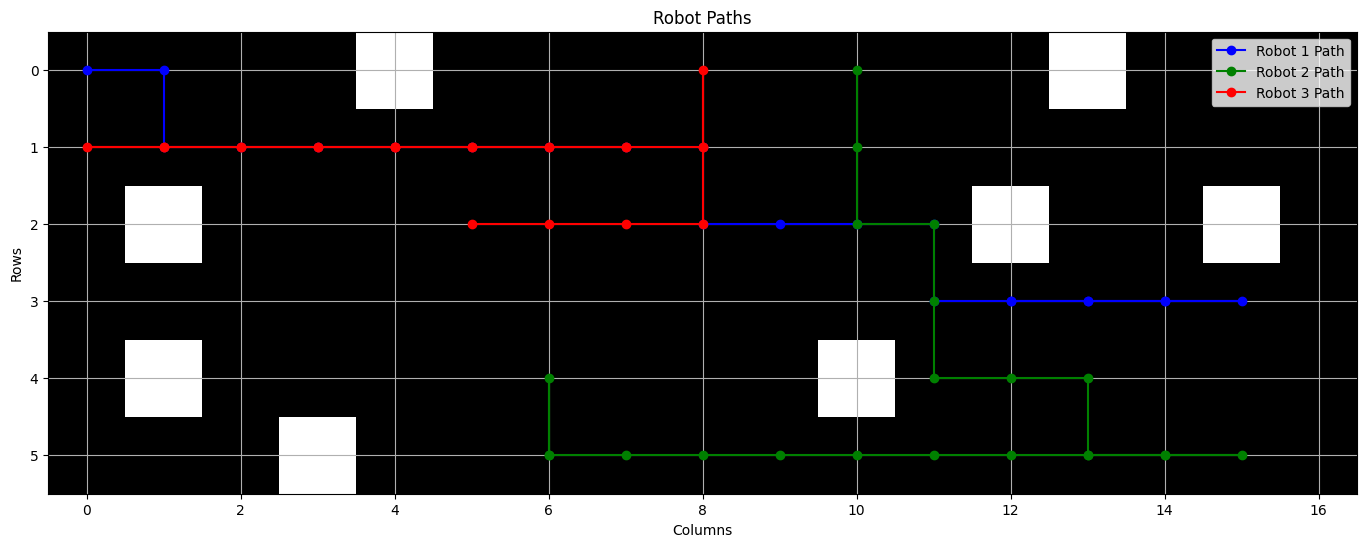

In [90]:
def main():
    grid = [
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]

    product_pickup_and_drop = [
        [GridCell(1, 0), GridCell(0, 8)],
        [GridCell(4, 6), GridCell(5, 15)],
        [GridCell(3, 14), GridCell(3, 15)]
    ]

    solution = CBSNode()
    min_cost = float('inf')

    for i in range(3):
        product_for_robot_1 = i
        product_for_robot_2, product_for_robot_3 = None, None
        second_assigned = False

        for j in range(3):
            if i != j:
                if not second_assigned:
                    product_for_robot_2 = j
                    second_assigned = True
                else:
                    product_for_robot_3 = j

        robots_with_product_permut_1 = [
            Robot(GridCell(0, 0), product_pickup_and_drop[product_for_robot_1][0],
                  product_pickup_and_drop[product_for_robot_1][1], GridCell(3, 12)),
            Robot(GridCell(5, 6), product_pickup_and_drop[product_for_robot_2][0],
                  product_pickup_and_drop[product_for_robot_2][1], GridCell(0, 10)),
            Robot(GridCell(1, 7), product_pickup_and_drop[product_for_robot_3][0],
                  product_pickup_and_drop[product_for_robot_3][1], GridCell(2, 5))
        ]

        robots_with_product_permut_2 = [
            Robot(GridCell(0, 0), product_pickup_and_drop[product_for_robot_1][0],
                  product_pickup_and_drop[product_for_robot_1][1], GridCell(3, 12)),
            Robot(GridCell(5, 6), product_pickup_and_drop[product_for_robot_3][0],
                  product_pickup_and_drop[product_for_robot_3][1], GridCell(0, 10)),
            Robot(GridCell(1, 7), product_pickup_and_drop[product_for_robot_2][0],
                  product_pickup_and_drop[product_for_robot_2][1], GridCell(2, 5))
        ]

        temp_solution_1 = cbs(robots_with_product_permut_1, grid)
        temp_solution_2 = cbs(robots_with_product_permut_2, grid)

        if temp_solution_1.cost < temp_solution_2.cost:
            if min_cost > temp_solution_1.cost:
                solution = temp_solution_1
        else:
            if min_cost > temp_solution_2.cost:
                solution = temp_solution_2

    if not solution.agent_paths:
        print("No solution found.")
    else:
        print(f"Solution found with total cost: {solution.cost}")
        for i, path in enumerate(solution.agent_paths):
            print(f"Robot {i + 1} path: {[(cell.x, cell.y) for cell in path]}")
    plot_paths(grid, solution)
if __name__ == "__main__":
    main()
